# Nanopore Read Analysis
Mostly by David Li, with some tweaks by Max Wilkinson

Analysis of DRT2 nanopore sequencing data generated from in vitro cDNA production, RNase clean-up, 3' adaptor ligation with 5app ligase, second strand synthesis, and nanopore ligation sequencing kit

Strategy:
- Filter reads for specific expected structure
    - NanoporeAdaptor - Read - RE1021 for cDNA+ strand
    - NanoporeAdaptor - RE1021_RC - Read - NanoporeAdaptor_RC for cDNA- strand
- Output reads fitting either filter, and also reads failing to pass filter
- Make a lookup and hash on 11 bps start and end to see biggest transitions

In [12]:
#Import helpful packages
import numpy as np


#Packages for data analysis and plotting

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator)
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.colors as colors

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['xtick.major.width'] = 0.5
matplotlib.rcParams['ytick.major.width'] = 0.5

matplotlib.rcParams['patch.force_edgecolor'] = False
matplotlib.rcParams['patch.linewidth'] = 0.5


#Packages for sequence parsing
import regex as re 
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import SeqFeature
from Bio.SeqFeature import SeqFeature, FeatureLocation, ExactPosition, BeforePosition, AfterPosition


from collections import Counter

#Some colours

hanpink = "#DC3860"
hanpink_dark = "#C63F59"
hanpink_light = "#F1617A"
hanpink_lightest = "#E686AC"
hanpinkpalette = [hanpink_dark, hanpink, hanpink_light, hanpink_lightest]

darkgrey = "#737880"
midgrey = "#949598"
lightgrey = "#C8CECE"
lightestgrey = "#DBDAD5"
greypalette = [darkgrey, midgrey, lightgrey, lightestgrey]

pinkgreypalette = []
for i in range(4):
    if i%2 == 0:
        pinkgreypalette.append(hanpinkpalette[-i])
    else:
        pinkgreypalette.append(greypalette[-i])

drtpalette = ["#B0492E", "#EB6E4A", "#E39625", "#F5D9AF"]


## Filtering out reads

We will split reads into a few types and will output both the filtered reads and the trimmed reads
 - 1: NanoporeAdaptor - read - RE1021 in last 100 bp
 - 2: NanoporeAdaptor - RE1021_RC in the next 100 bp
 - 3: Any other read with easily detectable NanoporeAdaptor in first 500 bp
 - 4: Anything left over
 


In [10]:
# Initialize variables
num_reads = 0
group1_reads = 0
group2_reads = 0
group3_reads = 0
group4_reads = 0
group1_reads_list = []
group1trimmed_reads_list = []
group2_reads_list = []
group2trimmed_reads_list = []
group3_reads_list = []
group3trimmed_reads_list = []
group4_reads_list = []

# Process input strings and define regexes
NanoporeAdaptor = "TGTACTTCGTTCAGTTACGTATTGCT" # aka SQK-NSK007
RE1021 = "CTGTCTCTTATACACATCTCCGAGCCCACGAGAC"
RE1439 ="GTCTCGTGGGCTCGGAGATGTGTATAAGAGACAG" # aka RE1021 RC

allowed_errors = 5
error_string = "{"+f"e<={allowed_errors}"+"}"   
adaptor_pattern = f"(?e)({NanoporeAdaptor}){error_string}"
RE1021_pattern = f"(?e)({RE1021}){error_string}"
RE1439_pattern = f"(?e)({RE1439}){error_string}"

# Extract and iterate through reads from .fastq file
# Reads are not in GitHub repository due to size limits, please download from NCBI SRA instead
readiter_f = SeqIO.parse("all_passed_guppy_reads.fastq", "fastq")
for record_f in readiter_f:
    num_reads += 1
    read_sequence_f = str.upper(str(record_f.seq))
    
    if len(read_sequence_f) >=500:
        read_start = read_sequence_f[:500]
    else:
        read_start = read_sequence_f
    
    adaptor_match = re.search(adaptor_pattern, read_start)
    if adaptor_match:
        trimmed = record_f.upper()
        trimmed = trimmed[adaptor_match.end():]
        trimmed_start = str.upper(str(trimmed.seq[:100]))
        trimmed_end = str.upper(str(trimmed.seq[-100:]))
        trimmed_end_match = re.search(RE1021_pattern, trimmed_end)
        if trimmed_end_match:
            group1_reads += 1
            group1_reads_list.append(record_f)
            trimmed = trimmed[:-(100-trimmed_end_match.start())]
            group1trimmed_reads_list.append(trimmed)
        else:
            trimmed_start_match = re.search(RE1439_pattern, trimmed_start)
            if trimmed_start_match:
                group2_reads += 1
                group2_reads_list.append(record_f)
                trimmed = trimmed[trimmed_start_match.end():]
                group2trimmed_reads_list.append(trimmed)
            else:
                group3_reads += 1
                group3_reads_list.append(record_f)
                group3trimmed_reads_list.append(trimmed)                            
    else:
        group4_reads += 1
        group4_reads_list.append(record_f)

         
# Output statistics and write .fastq files
print(num_reads," total reads, ", group1_reads," group 1 reads, ", group2_reads," group 2 reads, ", group3_reads," group 3 reads, and ", group4_reads," group 4 reads")
              

# Crashed here!
clean_group1trimmed_reads = []
for read in group1trimmed_reads_list:
    if type(read) == type(group1trimmed_reads_list[0]):
        clean_group1trimmed_reads.append(read)

SeqIO.write(clean_group1trimmed_reads, "Group1TrimmedReads.fastq", "fastq")

clean_group2trimmed_reads = []
for read in group2trimmed_reads_list:
    if type(read) == type(group1trimmed_reads_list[0]):
        clean_group2trimmed_reads.append(read)

SeqIO.write(clean_group2trimmed_reads, "Group2TrimmedReads.fastq", "fastq")

clean_group3trimmed_reads = []
for read in group3trimmed_reads_list:
    if type(read) == type(group1trimmed_reads_list[0]):
        clean_group3trimmed_reads.append(read)

SeqIO.write(clean_group3trimmed_reads, "Group3TrimmedReads.fastq", "fastq")                  

0it [00:00, ?it/s]

1606094  total reads,  119787  group 1 reads,  133370  group 2 reads,  1231179  group 3 reads, and  121758  group 4 reads


1231179

# Hash table counting of reads

In [2]:
# Make a dictionary of substrings

ncRNAsequence = Seq("GCCCTAAACAAAGGTTTAGGGGTATTGTACAGGTTGTCAAGCCTCCCACAGGTCTTGGTGAAACCAATCACTGTGACGACGGTAAGCAACACTTGGATGATATTCATAATTGACTCCACGCTACTGATTACATTATACAGCATATCTAACATTTGCGGCGAGGTTCACAATTTGTATTTAGGTACTGATTGTGGATGAGAAGGTTGGAGAAAGACCACTTGGTTAAGCCGGAGGATGTGTCCTAGAATTGTCGCTATTCTGTCATCCTCCGGTTTTGCTAAT")
ncRNAsequence_RC = ncRNAsequence.reverse_complement()
rollingcirclejunction = Seq("ATATCTAACAGGTTGTCAAG")
rollingcirclejunction_RC = rollingcirclejunction.reverse_complement()

ncRNAsubstrings = []
for i in range(len(ncRNAsequence)-10):
    ncRNAsubstrings.append(ncRNAsequence[i:i+11])
for i in range(len(ncRNAsequence_RC)-10):
    ncRNAsubstrings.append(ncRNAsequence_RC[i:i+11])
for i in range(len(rollingcirclejunction)-10):
    ncRNAsubstrings.append(rollingcirclejunction[i:i+11])
for i in range(len(rollingcirclejunction_RC)-10):
    ncRNAsubstrings.append(rollingcirclejunction_RC[i:i+11])

# 11 basepairs is the minimum for a unique hash within ncRNA, still some redundancy with the RCA junction
substring_counter = Counter(ncRNAsubstrings)
print("Number of substrings: ", len(ncRNAsubstrings))
print("Number of unique substrings: ", len(substring_counter.keys()))

substrings_dict = {val:idx for idx, val in enumerate(substring_counter.keys())}
substrings_dict_for_lookup = {idx:val for idx, val in enumerate(substring_counter.keys())}
substrings_set = set(substrings_dict)

Number of substrings:  564
Number of unique substrings:  558


In [3]:
# Check where reads start and end

# Extract and iterate through reads from .fastq file
readiter_f = SeqIO.parse("Group1TrimmedReads.fastq", "fastq")
num_reads = 0
num_reads_start_unmatched = 0
unmatched_starts = []
num_reads_end_unmatched = 0
unmatched_ends = []
start_array = np.zeros((len(substrings_dict),2))

for record_f in readiter_f:
    num_reads += 1                               
    read_sequence_f = str.upper(str(record_f.seq))
    read_start = read_sequence_f[:11]
    read_end = read_sequence_f[-11:]
                                      
    if read_start in substrings_set:
        start_array[substrings_dict[read_start],0]+=1
    else:
        num_reads_start_unmatched += 1
        unmatched_starts.append(read_start)
    
    if read_end in substrings_set:
        start_array[substrings_dict[read_end],1]+=1
    else:
        num_reads_end_unmatched += 1
        unmatched_ends.append(read_end)


print(f"Total reads = {num_reads}, Unmatched starts = {num_reads_start_unmatched}, Unmatched ends = {num_reads_end_unmatched}")


Total reads = 119787, Unmatched starts = 57841, Unmatched ends = 72873


In [4]:
# print out sequence of most common element

substrings_dict_for_lookup[np.argmax(start_array[:, 0])]

# Starts most commonly at the DNA primer as seen in the cryoEM structure! - great :)
# 'CGATATGCTGT': 3080, 'GCATTATGCTG': 2141, 'GTATGCTGTAT': 1800, 'GAAGTATGCTG': 1727, 'TTATGCTGTAT': 1403, 'CATTATGCTGT': 1222
# Most common start reads that don't match are SNPs/indels on this most common start primer

Seq('GATATGCTGTA')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


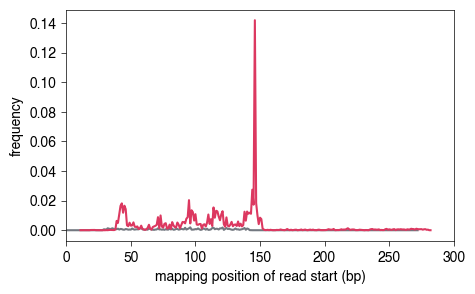

In [5]:
fig, ax = plt.subplots(figsize=(5,3))
sense_x = np.arange(0,272)
antisense_x = np.arange(272,544)

start_frequency = start_array[:,0]/start_array[:,0].sum()

ax.plot(1+sense_x, start_frequency[sense_x], color=darkgrey)
ax.plot(554- antisense_x, start_frequency[antisense_x], color=hanpink)
ax.set_xlim(0,300)
ax.set_xlabel('mapping position of read start (bp)')
ax.set_ylabel('frequency')
plt.savefig("Figure6B.pdf")

In [7]:
# Hash map of counting where things go now
# Check where reads start and end

# Extract and iterate through reads from .fastq file
readiter_f = SeqIO.parse("Group1TrimmedReads.fastq", "fastq")

num_reads = 0
num_reads_jumpstart_unmatched = 0
unmatched_jumpstarts = []
num_reads_jumpend_unmatched = 0
unmatched_jumpends = []
good_jumpreads = 0
reads_with_good_jumps = 0
read_jump_array = np.zeros((len(substrings_dict),len(substrings_dict)))

for record_f in readiter_f:
    num_reads += 1                               
    read_sequence_f = str.upper(str(record_f.seq))

    has_good_jumps = False
    
    for i in range(len(read_sequence_f)-21):
        current_seq = read_sequence_f[i:i+22]
        current_seq_start=current_seq[:11]
        current_seq_end=current_seq[11:]
        if current_seq_start in substrings_set:
            if current_seq_end in substrings_set:
                good_jumpreads += 1
                has_good_jumps = True
                read_jump_array[substrings_dict[current_seq_start],substrings_dict[current_seq_end]]+=1
            else:
                num_reads_jumpend_unmatched += 1
                unmatched_jumpends.append(current_seq_end)
        else:
            num_reads_jumpstart_unmatched += 1
            unmatched_jumpstarts.append(current_seq_start)
    if has_good_jumps:
        reads_with_good_jumps +=1

print(f"Total reads = {num_reads}, Good jumpreads = {good_jumpreads}, Reads with good jumps = {reads_with_good_jumps}, Unmatched jumpstarts = {num_reads_jumpstart_unmatched}, Unmatched jumpends = {num_reads_jumpend_unmatched}")


Total reads = 119787, Good jumpreads = 24520973, Reads with good jumps = 119067, Unmatched jumpstarts = 12217131, Unmatched jumpends = 6767075


In [8]:
np.save('read_jump_array.npy', read_jump_array)

# Fig 6C
# The big jumpmap

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


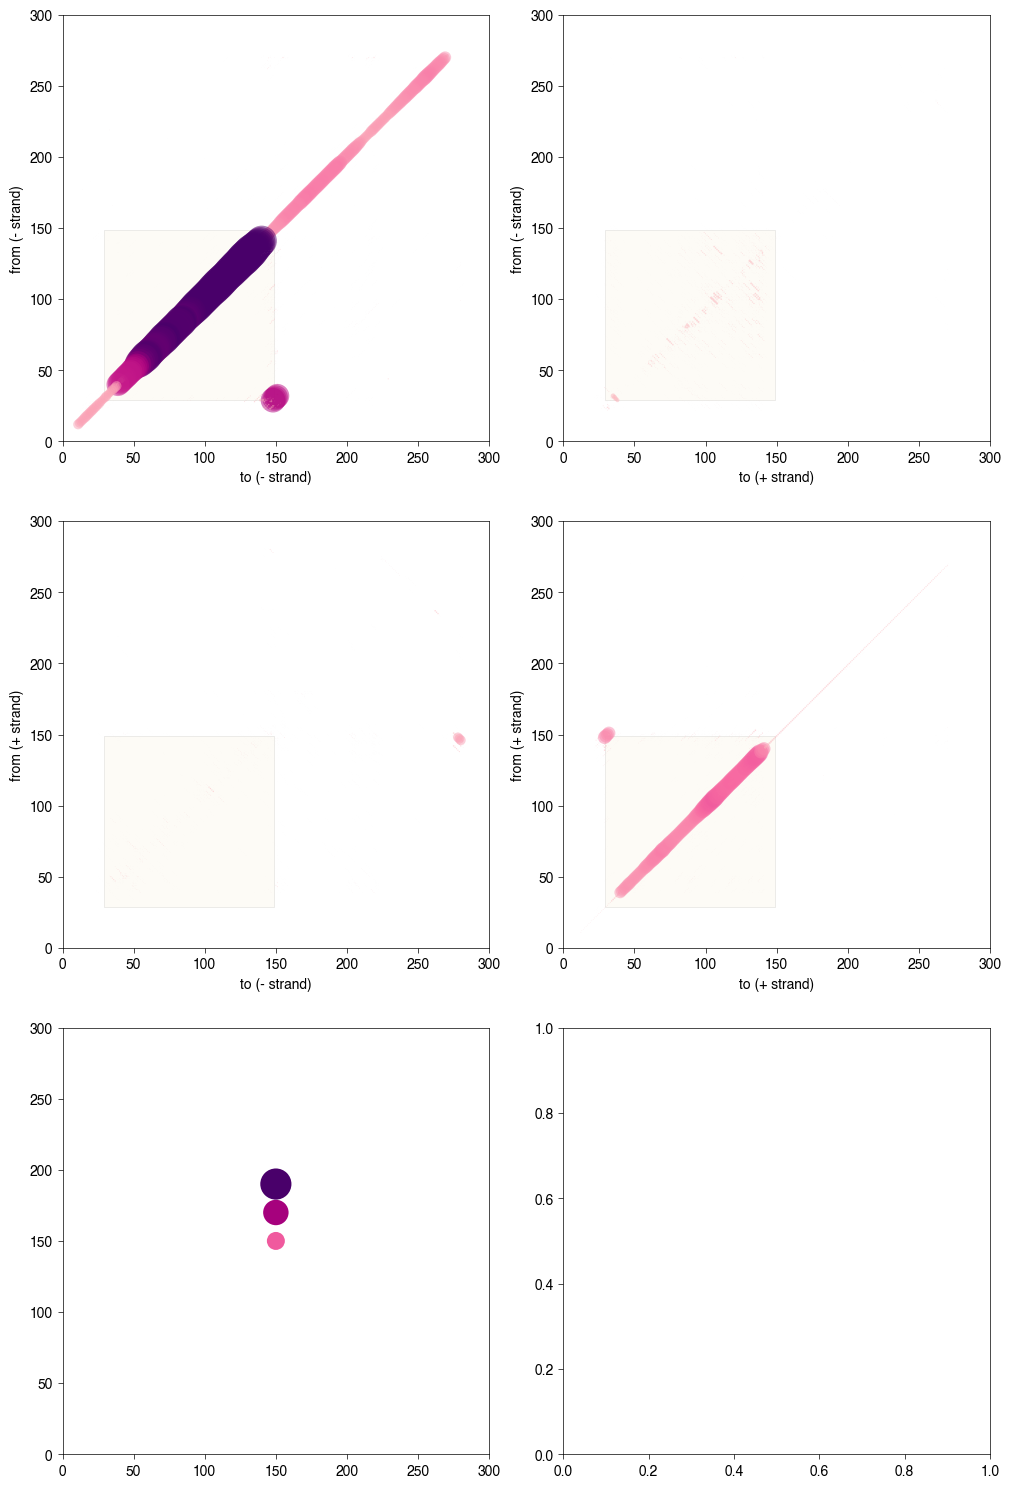

In [10]:
read_jump_array = np.load('read_jump_array.npy', allow_pickle=True)

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10,15), layout='constrained')

circles_plustoplus = []
circles_plustominus = []
circles_minustoplus = []
circles_minustominus = []

jumps_plustoplus = []
jumps_plustominus = []
jumps_minustoplus = []
jumps_minustominus = []

off_diagonals = np.zeros(4)
on_diagonals = np.zeros(4)
mostjumps = read_jump_array.max()

radius_scalefactor = 12
radii = np.sqrt(read_jump_array)/np.sqrt(mostjumps) * radius_scalefactor

legend_jumps = np.array([50000,100000,150000])
legend_radii = np.sqrt(legend_jumps)/np.sqrt(mostjumps) * radius_scalefactor
legend_circles = []

for fromread in range(0,533):
    for toread in range(11,544):
        jumps = read_jump_array[fromread,toread]
        radius = radii[fromread,toread]

        if jumps < 2:
            continue

        if fromread < 272:
            # it is from positive strand
            if toread < 272:
                jumps_plustoplus.append(jumps)
                circles_plustoplus.append(plt.Circle((toread+1, fromread+11), radius=radius))
                if toread-fromread-10 == 1:
                    on_diagonals[0]+=jumps
                else:
                    off_diagonals[0]+=jumps
            else:
                jumps_plustominus.append(jumps)
                circles_plustominus.append(plt.Circle((554-toread, fromread+11), radius=radius))
                off_diagonals[1]+=jumps
        else:
            if toread < 272:
                jumps_minustoplus.append(jumps)
                circles_minustoplus.append(plt.Circle((toread+1, 544-fromread), radius=radius))
                off_diagonals[2]+=jumps
            else:
                jumps_minustominus.append(jumps)
                circles_minustominus.append(plt.Circle((554-toread, 544-fromread), radius=radius))
                if 10-toread+fromread-10 == -11:
                    on_diagonals[3]+=jumps
                else:
                    off_diagonals[3]+=jumps


for n, radius in enumerate(legend_radii):
    legend_circles.append(plt.Circle((150, 150 + 20 * n), radius = radius))


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def set_axes(axis=ax):
    ax.set_xlim((0,300))
    ax.set_ylim((0,300))

cmap = plt.get_cmap('RdPu')
new_cmap = truncate_colormap(cmap, 0.3, 1)
alpha =0.5

for ax in axes.ravel()[0:4]:
    template_background = Rectangle((29,29),120,120, facecolor=drtpalette[3], alpha=0.1, ec='k')
    ax.add_patch(template_background)

cmin = 0
cmax = 150000

ax = axes.ravel()[3]
col = PatchCollection(circles_plustoplus, array = jumps_plustoplus, cmap=new_cmap, alpha=alpha)
col.set_clim([cmin,cmax])
ax.add_collection(col)
ax.set_ylabel("from (+ strand)")
ax.set_xlabel("to (+ strand)")
set_axes(axis=ax)

ax = axes.ravel()[2]
col = PatchCollection(circles_plustominus, array = jumps_plustominus, cmap=new_cmap, alpha=alpha)
col.set_clim([cmin,cmax])
ax.add_collection(col)
ax.set_ylabel("from (+ strand)")
ax.set_xlabel("to (- strand)")
set_axes(axis=ax)


ax = axes.ravel()[1]
col = PatchCollection(circles_minustoplus, array = jumps_minustoplus, cmap=new_cmap, alpha=alpha)
col.set_clim([cmin,cmax])
ax.add_collection(col)
ax.set_ylabel("from (- strand)")
ax.set_xlabel("to (+ strand)")
set_axes(axis=ax)

ax = axes.ravel()[0]
col = PatchCollection(circles_minustominus, array = jumps_minustominus, cmap=new_cmap, alpha=alpha)
col.set_clim([cmin,cmax])
ax.add_collection(col)
ax.set_ylabel("from (- strand)")
ax.set_xlabel("to (- strand)")
set_axes(axis=ax)



# for the legend
ax = axes.ravel()[4]
col = PatchCollection(legend_circles, array = legend_jumps, cmap=new_cmap, alpha=1)
col.set_clim([cmin,cmax])
ax.add_collection(col)
set_axes(axis=ax)
    
    

for ax in axes.ravel():
    ax.set_aspect('equal')

plt.savefig("Fig6C.pdf", transparent=True)


# Analyse features annotated with RepeatMasker


In [ ]:
! repeatmasker -e ncbi -pa 36 -q -no_is -nolow -norna -div 40 -lib repeat_masker_features.fasta Group1TrimmedReads.fasta -xm


In [24]:
read_dict={}
for seq_record in SeqIO.parse("Group1TrimmedReads.fastq", "fastq"):
    if seq_record.id not in read_dict:
        seq_record.annotations={"molecule_type": "DNA"}
        read_dict[seq_record.id]=seq_record

for line in open("Group1TrimmedReads.fasta.out.xm"):
    line=line.strip()
    line=line.split()
    seqid = line[4]
    try:
        seqr=read_dict[seqid]
    except:
        continue
    readlength=len(seqr)
    strand=line[8]
    start=int(line[5])
    end=int(line[6])
    if strand == '+':
        feature = SeqFeature(FeatureLocation(start-1, end, +1))
    else:
        feature = SeqFeature(FeatureLocation(start-1, end, -1))

    feature.qualifiers['class']=line[9].split("#")[0]
    feature.id=line[9].split("#")[0]
    feature.type=line[9].split("#")[0]
    seqr.features.append(feature)

SeqIO.write(list(read_dict.values()), "Group1TrimmedReads_annotated.gb", "genbank")

/Users/maxwilkinson/opt/anaconda3/envs/bioconda2/lib/python3.9/site-packages/Bio/SeqIO/InsdcIO.py:727: BiopythonWarning: Increasing length of locus line to allow long name. This will result in fields that are not in usual positions.
  warnings.warn(


119787

In [25]:
# Analyse features

readiter_f = SeqIO.parse("Group1TrimmedReads_annotated.gb", "genbank")
num_reads = 0
possible_features=[]
read_descriptors=[]
vector_template={'NanoporeAdapter':0, 'UG2_5prime':1, 'UG2template':2, 'UG2_3prime':3, 'RE1021':4, 'NanoporeAdapter_RC':5, 'UG2_5prime_RC':6, 'UG2template_RC':7, 'UG2_3prime_RC':8, 'RE1021_RC':9, 'SimpleRepeat':10}

for record_f in readiter_f:
    num_reads += 1
    read_descriptor=[]
    features = record_f.features
    strands = [x.strand for x in features]
    types = [x.type for x in features]
    for x in zip(types,strands):
        if x[1] == -1:
            feature_key = x[0]+'_RC'
        else:
            feature_key = x[0]
        if feature_key in vector_template:
            feature_index = vector_template[feature_key]
        else:
            feature_index = vector_template['SimpleRepeat']
        if read_descriptor and read_descriptor[-1][feature_index]>0:
            read_descriptor[-1][feature_index]+=1
        else:
            read_descriptor.append(np.zeros(len(vector_template.keys())))
            read_descriptor[-1][feature_index]+=1
    read_descriptor=np.array(read_descriptor)
    read_descriptors.append(read_descriptor)

/Users/maxwilkinson/opt/anaconda3/envs/bioconda2/lib/python3.9/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


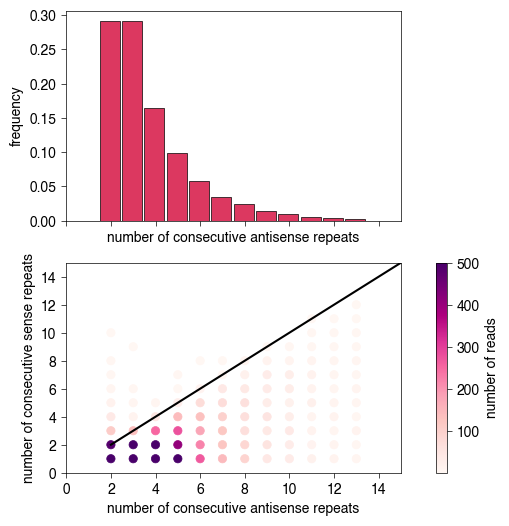

In [29]:
fig ,axes = plt.subplots(figsize=(5,6), nrows=2,ncols=2, sharex=True, height_ratios = [1,1], width_ratios = [95,5])
from matplotlib.ticker import MaxNLocator

ax = axes[0,0]
bins=np.arange(0,15,1)
ax.hist(length_longest_run,bins=bins,color=hanpink,width=0.9,density=True, align='left',edgecolor='k')
ax.set_xlabel("number of consecutive antisense repeats")
ax.set_ylabel("frequency")

ax = axes[1,0]
H, xedge, yedge = np.histogram2d(thresholded_pairs[:,0].astype(int), thresholded_pairs[:,1].astype(int), bins = np.arange(1,15))
y,x = np.meshgrid(xedge[:-1], yedge[:-1])
mask = H.ravel() > 1
threshold = 500
color_values = np.minimum(H.ravel()[mask], threshold)
sc = ax.scatter(x.ravel()[mask], y.ravel()[mask], c=color_values, cmap='RdPu')
ax.set_xlabel("number of consecutive antisense repeats")
ax.set_ylabel("number of consecutive sense repeats")
ax.plot(np.arange(2,20),np.arange(2,20), c='k')
ax.set_xlim((0,15))
ax.set_ylim((0,15))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax = axes[1,1]
fig.colorbar(sc, ax = ax, fraction=1, label='number of reads')
ax.axis("off")
axes[0,1].axis("off")

plt.savefig("FigS8.pdf", transparent=True)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


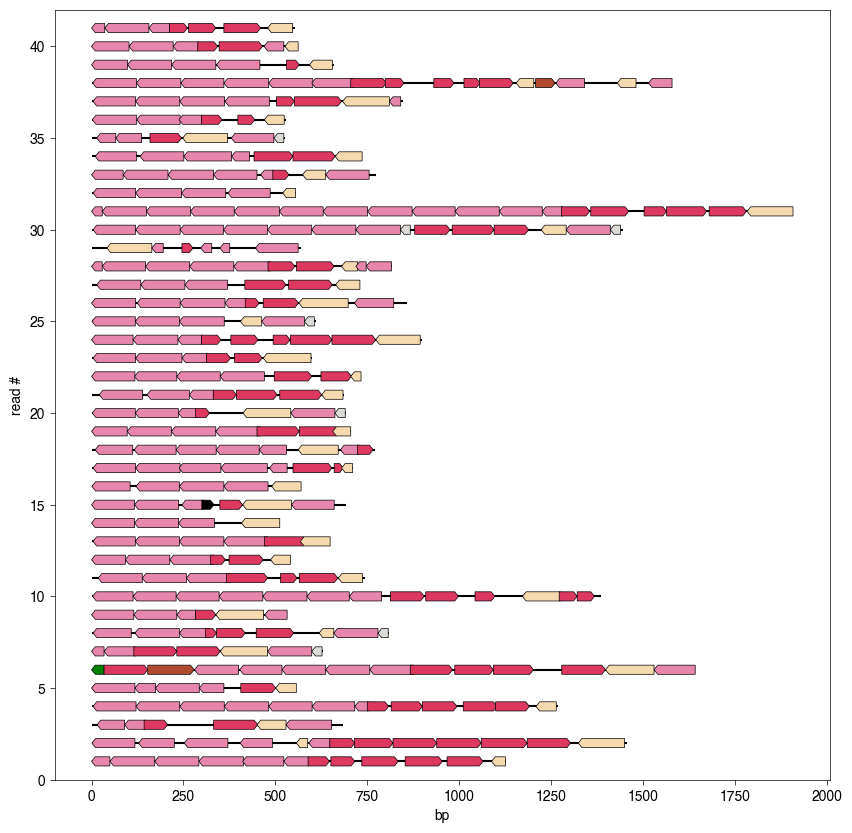

In [30]:
# show some example reads with multiple antisense repeats and with 3prime RC region and >500bp in length

def draw_arrow(start, length, width, y, pointiness, axis, direction='r', edgecolor='k', fillcolor=hanpink):
    if direction == 'r':
        axis.fill([start, start+length-pointiness, start+length, start+length-pointiness, start],[y-width/2, y-width/2, y, y+width/2, y+width/2], edgecolor=edgecolor, fc=fillcolor, zorder=100)
    else:
        axis.fill([start, start+pointiness, start+length, start+length, start+pointiness],[y, y-width/2, y-width/2, y+width/2, y+width/2], edgecolor=edgecolor, fc=fillcolor, zorder=100)


fig, ax = plt.subplots(figsize=(10,10))

readiter = SeqIO.parse("Group1TrimmedReads_annotated.gb", "genbank")
y = 0
max_x = 0
n=0

max_examples = 40
example_reads = np.arange(8,20000,100)

feature_colors = {
    "UG2_3prime" : (drtpalette[3],drtpalette[0]),
    "UG2template" : (hanpink_lightest,hanpink),
    "UG2_5prime" : (lightestgrey,darkgrey),
    "RE1021" : ('g','k')
}

for record in readiter:
    n+=1
    if len(record) < 500:
        continue
    if y > max_examples:
        break
    
    read_descriptor = read_descriptors[n-1]   
    sense_repeats = read_descriptor[:,vector_template['UG2template']].max()
    antisense_repeats = read_descriptor[:,vector_template['UG2template_RC']].max()
    if antisense_repeats < 2 :
        continue
    if read_descriptor[:,vector_template['UG2_3prime_RC']].max() == 0:
        continue
    
    y+=1

    #draw whole read
    ax.hlines(y, 0, len(record), color='k')

    for feature in record.features:
        start = int(feature.location.start)
        end = int(feature.location.end)
        region = feature.type
        if end > max_x:
            max_x = end
        strand = int(feature.location.strand)

        if strand == -1:
            direction = 'l'
            color = feature_colors[region][0]
        else:
            direction = 'r'
            color = feature_colors[region][1]
        draw_arrow(start, end-start, 0.5, y, 10, axis = ax, direction = direction, fillcolor=color)
    

ax.set_xlim((-100,max_x+100))
ax.set_ylim((0, y+1))

ax.set_xlabel('bp')
ax.set_ylabel('read #')
plt.savefig("FigS8B.pdf")